**线性回归**是一种 $\mbox{parametric learning algorithm}$，而**局部加权线性回归**是一种 $\mbox{non-parametric learning algorithm}$. 

$\mbox{Parametric learning algorithm}$ 有固定的（指的是：值的大小是固定）、有限的参数，通过训练样本，找到合适的参数后，对于之后未知的输入，我们可以直接利用这组参数得出其相应的预测输出。而 $\mbox{non-parametric learning algorithm}$ 需要的计算量与输入的训练集大小成正比，对于每次新的输入，需重新计算相应参数后，才能求取相应的预测输出。

**局部加权回归**：
- *局部*是因为目标函数的逼近主要根据查询点附近的数据
- *加权*是因为每一个训练样例的贡献是由它与查询点间的距离加权的
- *回归*是因为统计学习界广泛使用这个术语来表示逼近实数值函数的问题

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from math import *

In [2]:
# x取1~100,y取某一个非线性函数
x = np.arange(1, 101)
x = np.array([float(i) for i in x])

# 添加干扰：从均值为0，标准差为1.5的正态分布生成100个随机数
y = x + [10*sin(0.3*i) for i in x] + stats.norm.rvs(size=100, loc=0, scale=1.5)

In [3]:
# 画图用的包
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

# Seaborn is a Python visualization library based on matplotlib. 
import seaborn as sns

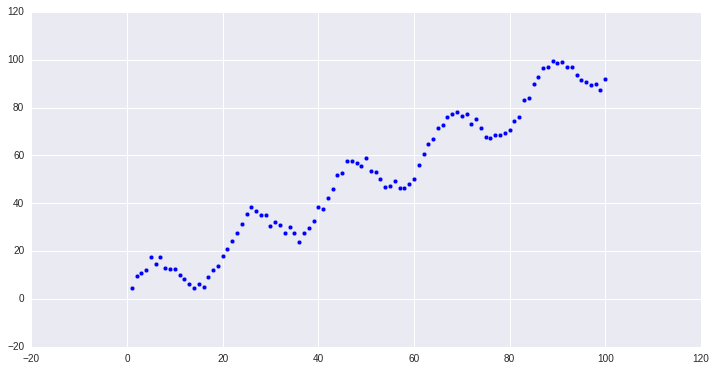

In [4]:
plt.figure(figsize=(12, 6))
plt.scatter(x, y)

y = 1.93644541286 + 0.966700947504* x


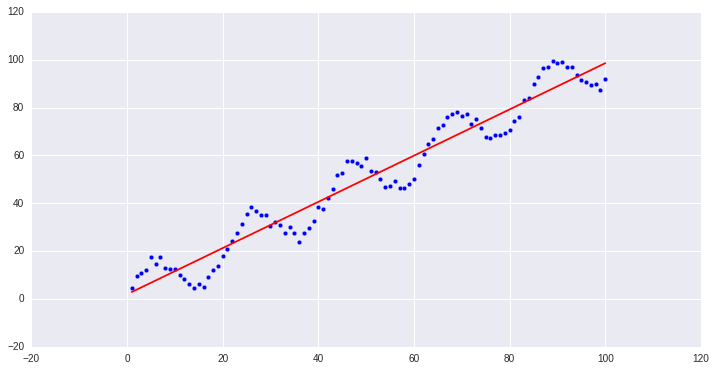

In [5]:
# 先使用最小二乘法
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.figure(figsize = (12, 6))
yHatLinear = intercept + slope * x
plt.plot(x, yHatLinear, 'r')
plt.scatter(x, y)
print('y = ' + str(intercept) + ' + ' + str(slope) + '* x')

可以看到，直接用直线来拟合有些牵强，并不是一个线性的关系，这样回归的结果并不好。

那么，可以使用局部加权线性回归来对这个模型进行拟合：

- 使用高斯核函数计算回归时第 $i$ 个样本处，其他样本的权重 $W$
- 用权重 $w$ 对第 $i$ 个样本做加权线性回归，得到归于第 $i$ 个样本的回归方程
- 通过回归方程得到样本而 $x_i$ 的估计值 $\hat y_i$
- 重复以上步骤，得到所有样本的估计值

In [6]:
# 计算 局部加权线性回归的权重 的平方根

def get_sqrtW(x0, k):
    w = np.zeros(len(x))
    for i in range(len(x)):
        w[i] = exp( -(x[i]-x0)**2 / (2*k*k) )
    w = np.array([sqrt(i) for i in w])
    return w

In [7]:
# statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models

import statsmodels.api as sm

In [8]:
# 对不同的径向基宽度，得到不同的y的估计值
def get_yHat2(k):
    yHat2 = np.zeros(len(x))
    
    for i in range(len(x)):
        # 加权最小二乘转化成普通最小二乘
        w = get_sqrtW(x[i], k)
        
        x2 = w*x
        x2 = x2[x2>0] # 去掉样本权重为0的样本
        y2 = w*y
        y2 = y2[y2>0]
        
        X = np.zeros((1, len(x2)))
        X[0] = x2;
        X = X.T
        X = sm.add_constant(X, has_constant='skip')
        
        X[:, 0] = w[w>0]
        
        Y = y2
        
        model = sm.OLS(Y, X)
        results = model.fit()
        a = results.params[0]
        b = results.params[1]
        yHat2[i] = a + b*x[i]
        
    return yHat2

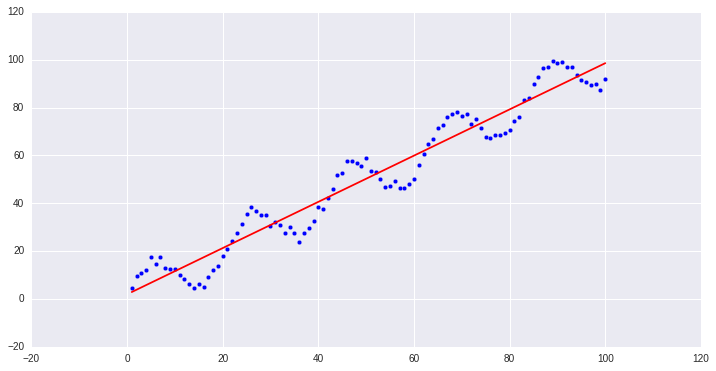

In [9]:
yHat2 = get_yHat2(100000) # k 取 100000
plt.figure(figsize=(12, 6))
plt.plot(x, yHat2, 'r')
plt.scatter(x, y) # 非常近似一条直线，且和OLS结果非常近似

In [10]:
# 比较 OLS 与 WOLS

data = pd.DataFrame()
data['y'] = y
data['yHatLinear'] = yHatLinear
data['yHat2'] = yHat2
data.head()

,y,yHatLinear,yHat2
0,4.715284,2.903146,2.903146
1,9.603280,3.869847,3.869847
2,10.728655,4.836548,4.836548
3,12.282009,5.803249,5.803249
4,17.342823,6.769950,6.769950


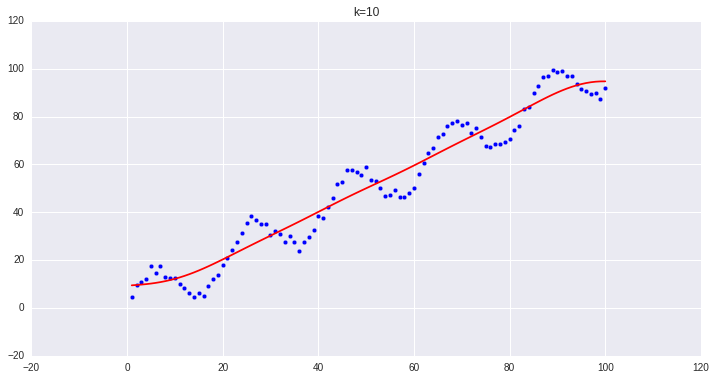

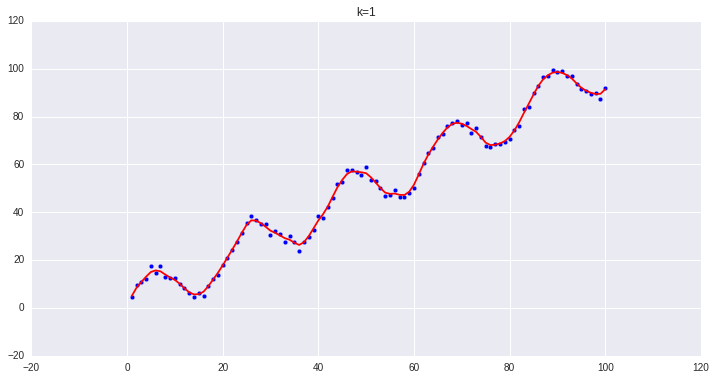

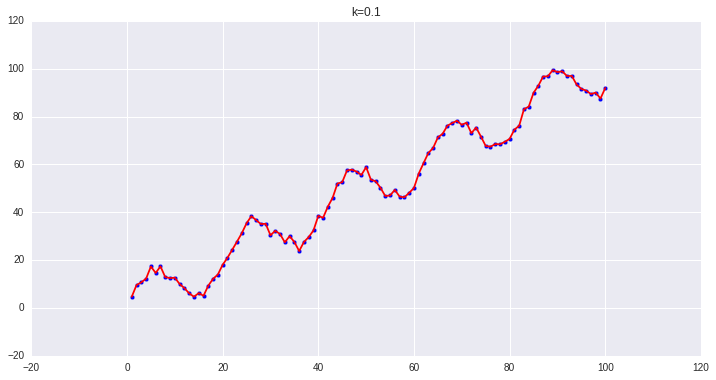

In [11]:
# 下面调整一下 k 的值，看看各种 k 值的拟合结果：

yHat2=get_yHat2(10)  
plt.figure(figsize=(12,6))
plt.plot(x,yHat2,'r')
plt.scatter(x,y)
plt.title('k=10')

yHat2=get_yHat2(1)  
plt.figure(figsize=(12,6))
plt.plot(x,yHat2,'r')
plt.scatter(x,y)
plt.title('k=1')

yHat2=get_yHat2(0.1)  
plt.figure(figsize=(12,6))
plt.plot(x,yHat2,'r')
plt.scatter(x,y)
plt.title('k=0.1')

可以看到，当ｋ越小时，拟合的效果越好，但是我们拟合的目的在于预测，需要避免过拟合的问题，这时候需要做 $\mathcal{Bias/Variance Trade-off}$:

![trade-off](img/trade_off.png)

所以，我们需要通过交叉验证，来确定 $k$ 的取值，使得预测误差最小。

#### References:

1. [加权最小二乘法与局部加权线性回归](https://uqer.io/community/share/57887c7e228e5b8a03932c66)

2. [局部加权线性回归](http://www.cnblogs.com/JiePro/p/MachineLearning_2.html)